
# Final project vizulations (Sunes work)



In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import folium
import urllib.request
import datetime
import plotly.express as px
from scipy import stats
from sklearn.linear_model import Ridge
from datetime import datetime, timedelta
from folium import plugins
from folium.plugins import HeatMap


In [2]:
#Preparing weather dataset:

months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
#Load weather data
df_w = pd.read_csv("Data/weather2.csv")
#Expand weather dataset more detailed date columns to later filter data for plots
df_w['Year'] = pd.DatetimeIndex(df_w['date']).year
df_w['MonthNo'] = pd.DatetimeIndex(df_w['date']).month
df_w['Month'] = df_w['MonthNo'].apply(lambda x: months[x-1])
df_w['dayofyear'] = pd.DatetimeIndex(df_w['date']).dayofyear
df_w['date'] = pd.DatetimeIndex(df_w['date']).date
df_w['dayofweek'] = pd.DatetimeIndex(df_w['date']).dayofweek
#Find and sort a distinct lits of years the dataset holds weather data for
weatheryears = df_w.Year.dropna().sort_values().unique()
yearstoplot = []
#Expand the list with values 0, 1, 2 to represent non-covid years, covid years and all years to include in the plots
for y in weatheryears:
    yearstoplot.append(y)
    yearstoplot.append(y)
yearstoplot.append(1)
yearstoplot.append(1)
yearstoplot.append(2)
yearstoplot.append(2)
yearstoplot.append(0)
yearstoplot.append(0)
    

In [3]:
#Read pedestrian dataset (Very large, 4 million rows)
df_p = pd.read_csv("Data/Pedestrian_Counting_System_-_Monthly__counts_per_hour_.csv") 
#Extract the date from the date-time column for and making a column for that, so the data can be directly compared to weather data
df_p['date'] = pd.DatetimeIndex(df_p['Date_Time']).date

In [4]:
#Add pedestrian data to weather dataset by comparing the dates of each dataset
df_w['walker_counts'] = df_w['date'].apply(lambda date: df_p[(df_p.date == date)]['Hourly_Counts'].sum())

In [5]:
def filterData(df, year, isWeekend):
    #Filter data for weekends (weekday 5 and 6) or workdays (weekdays 0 - 4)
    df = df[df.dayofweek.isin([5,6])] if isWeekend else df[df.dayofweek.isin([0,1,2,3,4])]
  
    #don't filter data for specific years if year = 0
    if (year == 0):
        return df
    #Here we select the years affected (2020, 2021) by covid-19
    if (year == 1):
        return df[(df.Year >= 2020)]
    #Here we select non-covid years
    elif (year == 2):
        return df[(df.Year < 2020)]
    #Otherwise a specific year must be selected
    return df[(df.Year == year)]


#Helper function to select data for precipitation plots
def getRainData(year, isWeekend = False):
    xValues = []
    xLabels = []
    #Filter the data with our prevously defined helper function
    df_wf = filterData(df_w, year, isWeekend)
  
    #Creating custom bin ranges
    for n in range(0,12,2):
        #Add binned data avarages to as x values. Starting with -2 to 0 (which will actually just be 0 as there is no negative precipitation).
        #Then increment by 2 mm each iteration for the bin size 
        xValues.append(df_wf[(df_wf.prcp > n-2) & (df_wf.prcp <= n)].walker_counts.mean())
        xLabels.append(f'{n-2} - {n}')
    #Add a final bin to just select everything above 10 mm precipitation.
    xValues.append(df_wf[(df_wf.prcp > 10)].walker_counts.mean())
    #Add the label for the final bin.
    xLabels.append('> 10')
    #Overwrite the first bin label to just say 0 instead of "-2 - 0"
    xLabels[0] = '0'
    #Return data as a pandas Series ready to be plotted
    return pd.Series(xValues, index = xLabels)


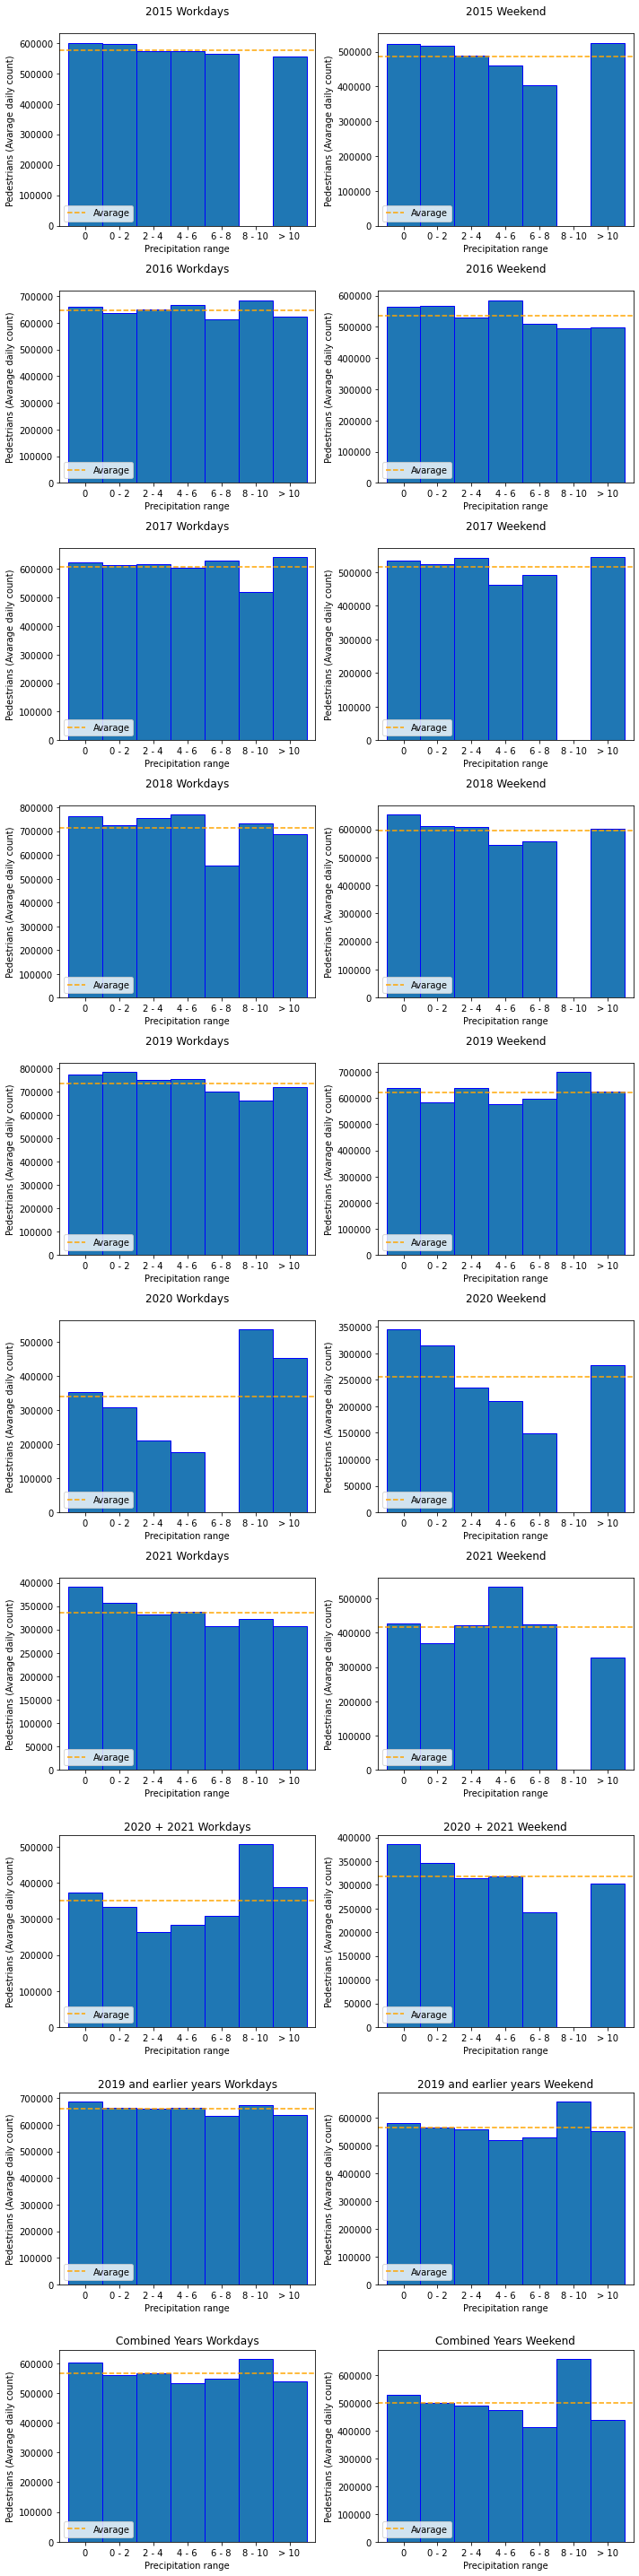

In [6]:
#Helpers functions to convert linear integer positon to 2D positons in a 2-column plot grid
def getRow (num):
    return int(num/2)

def getCol (num):
    return int(num%2)

def isWeekend(n): 
    return 1 == getCol(n)

def plotData(data,ylabel,rotation = 0):
    
    rowsNum = int(len(yearstoplot)/2)
    
    fig, ax = plt.subplots(nrows=rowsNum, ncols=2, figsize=(10,40))

    for n, yr in enumerate(yearstoplot):
        #Get data to plot from parameter provided function
        dataToPlot = data(yr, isWeekend(n))
        #Weekend/workday title string
        weekendTitle = 'Weekend' if isWeekend(n) else 'Workdays'
        #Actual plot command
        #Width set to almost 1 so the bars almost touch to adhere to standard histogram styling
        dataToPlot.plot.bar(title=f'{yr} {weekendTitle}\n', ax=ax[getRow(n),getCol(n)], width=1,edgecolor='b')
        #Grab the plot for styling/prettifying
        plot = ax[getRow(n),getCol(n)]
        #Add a dashed line showing the avarage
        plot.axhline(y=dataToPlot.mean(),color='orange', linestyle="--");
        plot.legend(loc="lower left",labels=['Avarage'])
        #Add x and y axis labels
        plot.set_ylabel('Pedestrians (Avarage daily count)');
        plot.set_xlabel(f'{ylabel} range');
        #Set label rotation for better readability
        plot.tick_params(axis='x', rotation=rotation)

    #The final 3 rows of plots are for plots of combined years
    #Overwriting titles accordingly 
    ax[rowsNum-3,0].set_title('2020 + 2021 Workdays');
    ax[rowsNum-3,1].set_title('2020 + 2021 Weekend');
    
    ax[rowsNum-2,0].set_title('2019 and earlier years Workdays');
    ax[rowsNum-2,1].set_title('2019 and earlier years Weekend');
    
    ax[rowsNum-1,0].set_title('Combined Years Workdays');
    ax[rowsNum-1,1].set_title('Combined Years Weekend');

    plt.tight_layout() 
    plt.show()

plotData(getRainData,'Precipitation',360)


In [7]:
def getWindData(year, isWeekend = False):
    xValues = []
    xLabels = []
    #Filter the data with our prevously defined helper function
    df_wf = filterData(df_w, year, isWeekend)
    
    #Define 5 custom bins for wind-speed ranges
    xValues.append(df_wf[(df_wf.prcp > 0) & (df_wf.wspd <= 10)].walker_counts.mean())
    xLabels.append('≤ 10')
    
    xValues.append(df_wf[(df_wf.prcp > 10) & (df_wf.wspd <= 15)].walker_counts.mean())
    xLabels.append('10 - 15')
    
    xValues.append(df_wf[(df_wf.prcp > 15) & (df_wf.wspd <= 20)].walker_counts.mean())
    xLabels.append('15 - 20')
    
    xValues.append(df_wf[(df_wf.prcp > 20) & (df_wf.wspd <= 25)].walker_counts.mean())
    xLabels.append('20 - 25')
        
    xValues.append(df_wf[(df_wf.prcp > 25)].walker_counts.mean())
    xLabels.append('> 25')
    
    return pd.Series(xValues, index = xLabels)

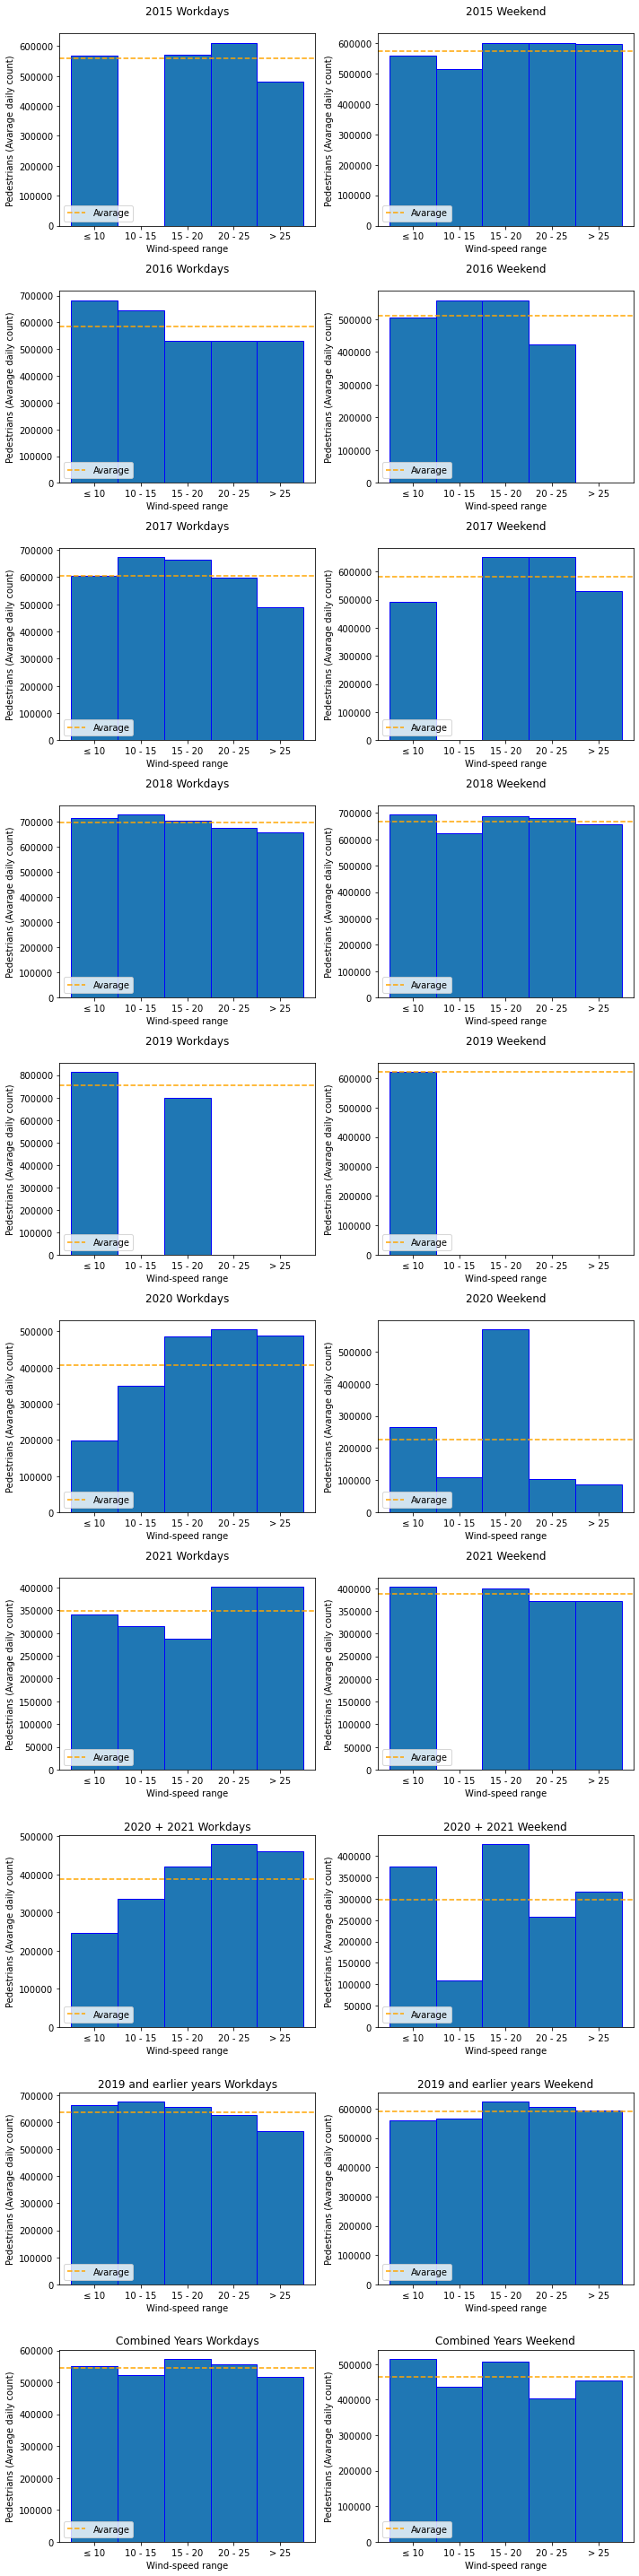

In [8]:
plotData(getWindData,'Wind-speed')

In [9]:
def getTempData(year, isWeekend = False):
    xValues = []
    xLabels = []
    #Filter the data with our prevously defined helper function
    df_wf = filterData(df_w, year, isWeekend)
    
    xValues.append(df_wf[(df_wf.tavg <= 8)].walker_counts.mean())
    #Add a label for the first bin to just show pedestrian data of less than 8 degrees
    xLabels.append('≤ 8')
    
    #Define and add 6 bins addition for temperature with a 3 degree interval
    for n in range(8,25,3):
        xValues.append(df_wf[(df_wf.prcp > n) & (df_wf.tavg <= n+3)].walker_counts.mean())
        xLabels.append(f'{n} - {n+3}')
    #Add a final bin for above 26 degrees
    xValues.append(df_wf[(df_wf.tavg > 26)].walker_counts.mean())

    xLabels.append('> 26')
    return pd.Series(xValues, index = xLabels)

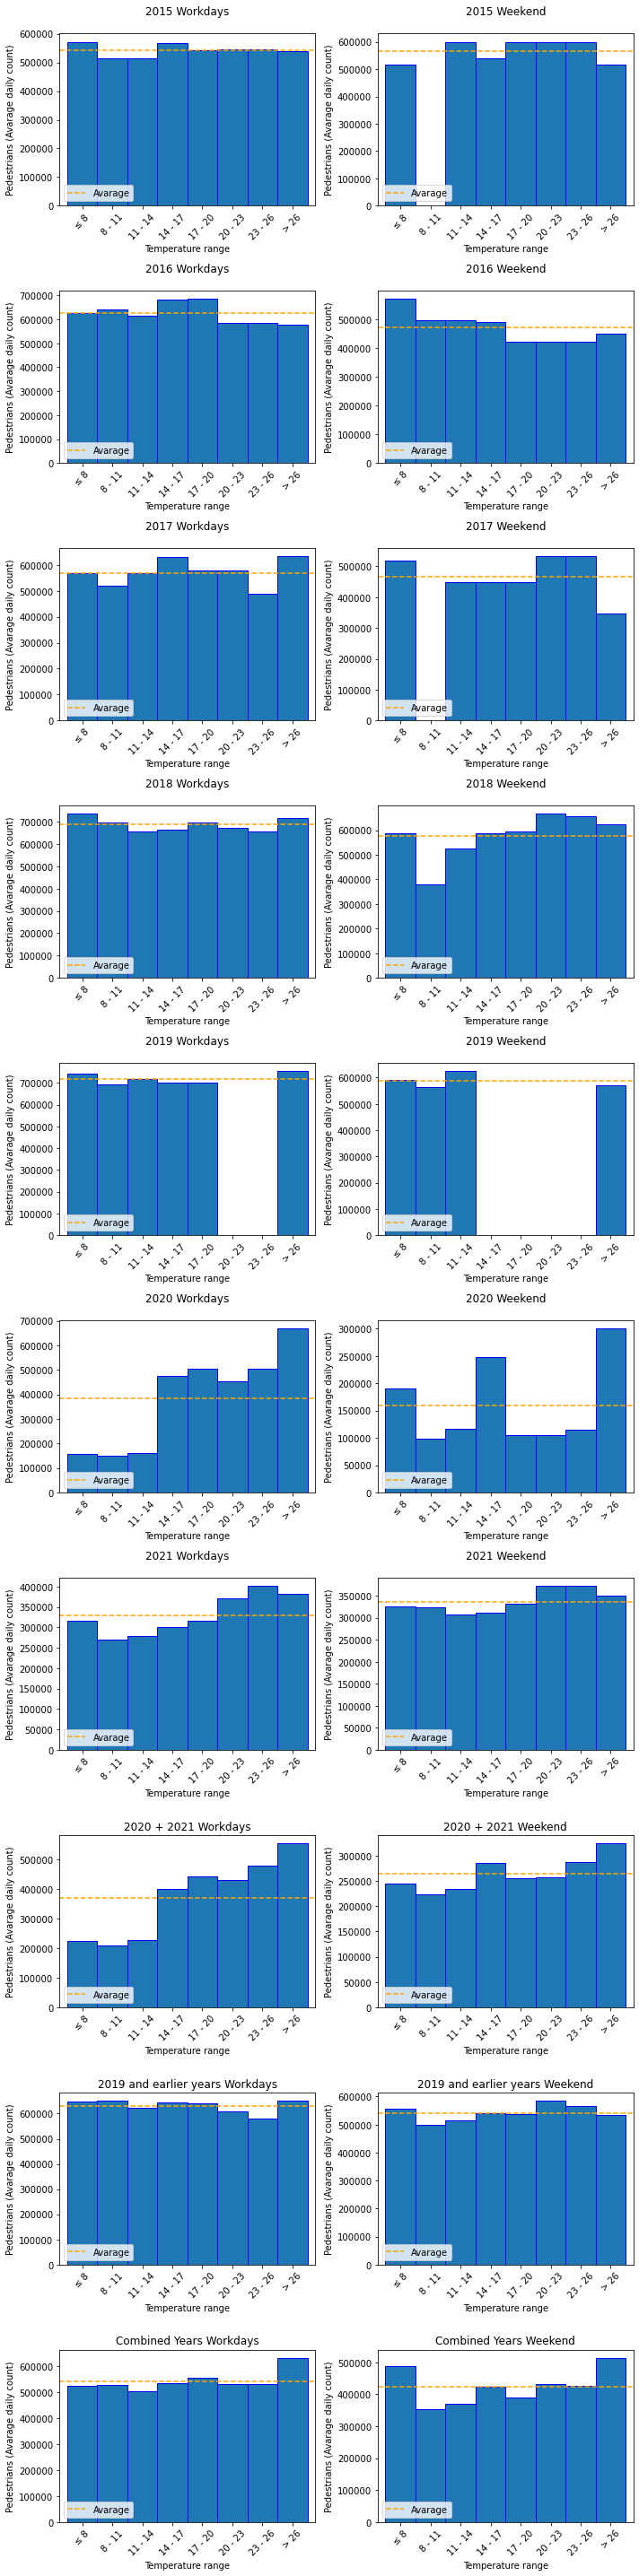

In [10]:
plotData(getTempData,'Temperature',45)


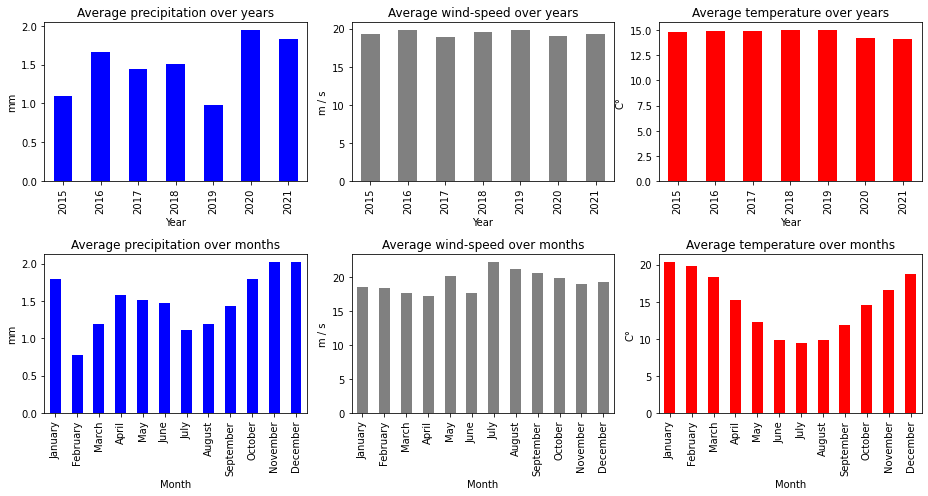

In [131]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(13,7))
df_w['Month'] = pd.Categorical(df_w['Month'], categories=months, ordered=True)

featuresToPlot = ['prcp','wspd','tavg']
titleLabels = ['precipitation','wind-speed','temperature']
colors = ['blue','grey','red']
yUnits = ['mm','m / s','C°']
for n, f in enumerate(featuresToPlot):
    df_w.groupby(df_w['Year']).mean()[f].plot.bar(color = colors[n],title=f'Average {titleLabels[n]} over years', ax = ax[(int(n/3)),(int(n%3))])
    ax[(int(n/3)),(int(n%3))].set_ylabel(yUnits[n]) 
    
for n, f in enumerate(featuresToPlot):
    df_w.groupby(df_w['Month']).mean()[f].plot.bar(color = colors[n],title=f'Average {titleLabels[n]} over months', ax = ax[(int((n+3)/3)),(int((n+3)%3))])
    ax[(int((n+3)/3)),(int((n+3)%3))].set_ylabel(yUnits[n]) 

plt.tight_layout() 
plt.show()